In [1]:
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import random

import numpy as np

import matplotlib.cm as cm

import pickle

from utils import functions

%matplotlib notebook

import os

In [2]:
# restoring variables from memory 
%store -r

In [4]:
def identify_BETTER_and_WORSE_alternative(noise_metrics_stats_data, metric_stats_data, metric): 
    values = metric_stats_data[:,:,0]
    std = metric_stats_data[:,:,1]
    noise_values = noise_metrics_stats_data[:,:,0]
    noise_std = noise_metrics_stats_data[:,:,1]
    if metric=='NRMSE' or metric=='RMSE':
        values_BETTER = torch.where(values < noise_values, values, 0)
        std_BETTER = torch.where(values < noise_values, std, 0)
        
        values_WORSE = torch.where(values >= noise_values, values, 0)
        std_WORSE = torch.where(values >= noise_values, std, 0)
    elif metric=='PSNR' or metric=='MS_SSIM' or metric=='SSIM': 
        values_BETTER = torch.where(values > noise_values, values, 0)
        std_BETTER = torch.where(values > noise_values, std, 0)
        
        values_WORSE = torch.where(values <= noise_values, values, 0)
        std_WORSE = torch.where(values <= noise_values, std, 0)
    else: 
        raise Exception("Unsupported metric")
    return [values_BETTER, std_BETTER, values_WORSE, std_WORSE]

In [41]:
metric_stats_CARE_list = [metric_stats_NRMSE_CARE_beam, metric_stats_RMSE_CARE_beam, metric_stats_PSNR_CARE_beam, metric_stats_SSIM_CARE_beam, metric_stats_MS_SSIM_CARE_beam]
metric_stats_NOISE_list = [metric_stats_NRMSE_beam, metric_stats_RMSE_beam, metric_stats_PSNR_beam, metric_stats_SSIM_beam, metric_stats_MS_SSIM_beam]
metrics_list = ['NRMSE', 'RMSE', 'PSNR', 'SSIM', 'MS_SSIM']

map_tensor = torch.zeros(metric_stats_NOISE_list[0][:,:,0].shape)

assert len(metric_stats_CARE_list) == len(metric_stats_NOISE_list) 
assert len(metric_stats_CARE_list) == len(metrics_list)

for idx in range(len(metric_stats_CARE_list)): 
    output_idx = identify_BETTER_and_WORSE_alternative(metric_stats_NOISE_list[idx], metric_stats_CARE_list[idx], metrics_list[idx])[0]
    map_tensor = torch.where(output_idx > 0, map_tensor+1, map_tensor)


In [36]:
# alternative view version - each metric separately 
# 5 separate tensor maps 
map_tensor_tem = torch.zeros(metric_stats_NOISE_list[0][:,:,0].shape)
map_tensor_5 = map_tensor_tem.repeat(5,1,1)

assert len(metric_stats_CARE_list) == len(metric_stats_NOISE_list) 
assert len(metric_stats_CARE_list) == len(metrics_list)

for idx in range(len(metric_stats_CARE_list)): 
    output_idx = identify_BETTER_and_WORSE_alternative(metric_stats_NOISE_list[idx], metric_stats_CARE_list[idx], metrics_list[idx])[0]
    map_tensor_5[idx,:,:] = torch.where(output_idx != 0, map_tensor_5[idx,:,:]+1, map_tensor_5[idx,:,:])

In [34]:
ticks_X = indices[0,0,:]
ticks_Y = indices[1,:,0]

In [46]:
from matplotlib import colors
# source: https://stackoverflow.com/questions/43971138/python-plotting-colored-grid-based-on-values
# create discrete colormap
cmap = colors.ListedColormap([ '#CDFFCD', '#87E487', '#45E145'])
bounds = [3,4,5]
norm = colors.BoundaryNorm(bounds, cmap.N)

y, x = np.meshgrid(ticks_X, ticks_Y)

z = map_tensor.numpy()

fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap=cmap)
ax.set_title('CARE network metrics improvement score - x/5 \n relative to metrics for low quality images vs their GT')

fig.colorbar(c, ax=ax)

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


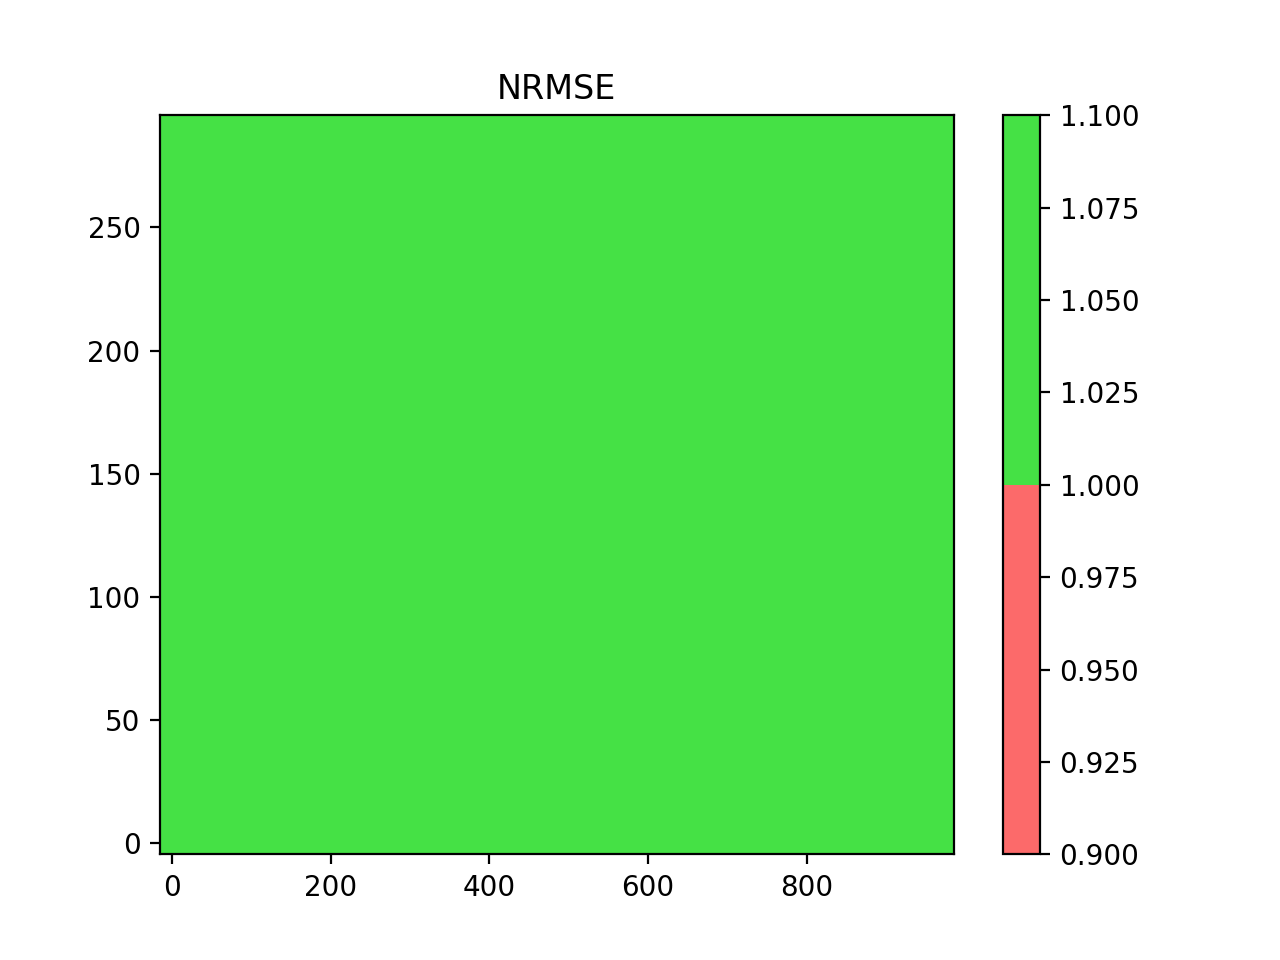

<IPython.core.display.Javascript object>


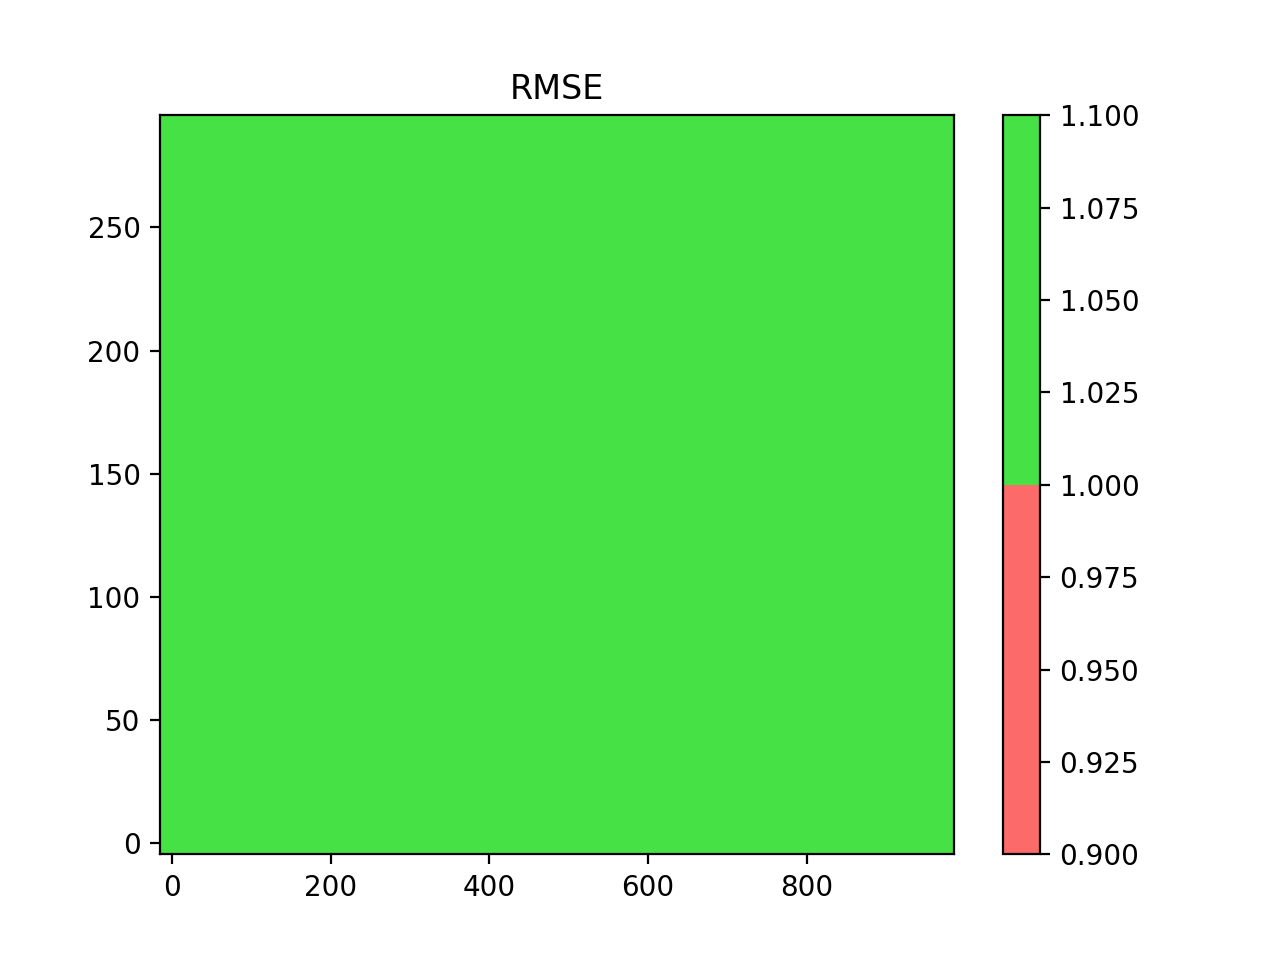

<IPython.core.display.Javascript object>


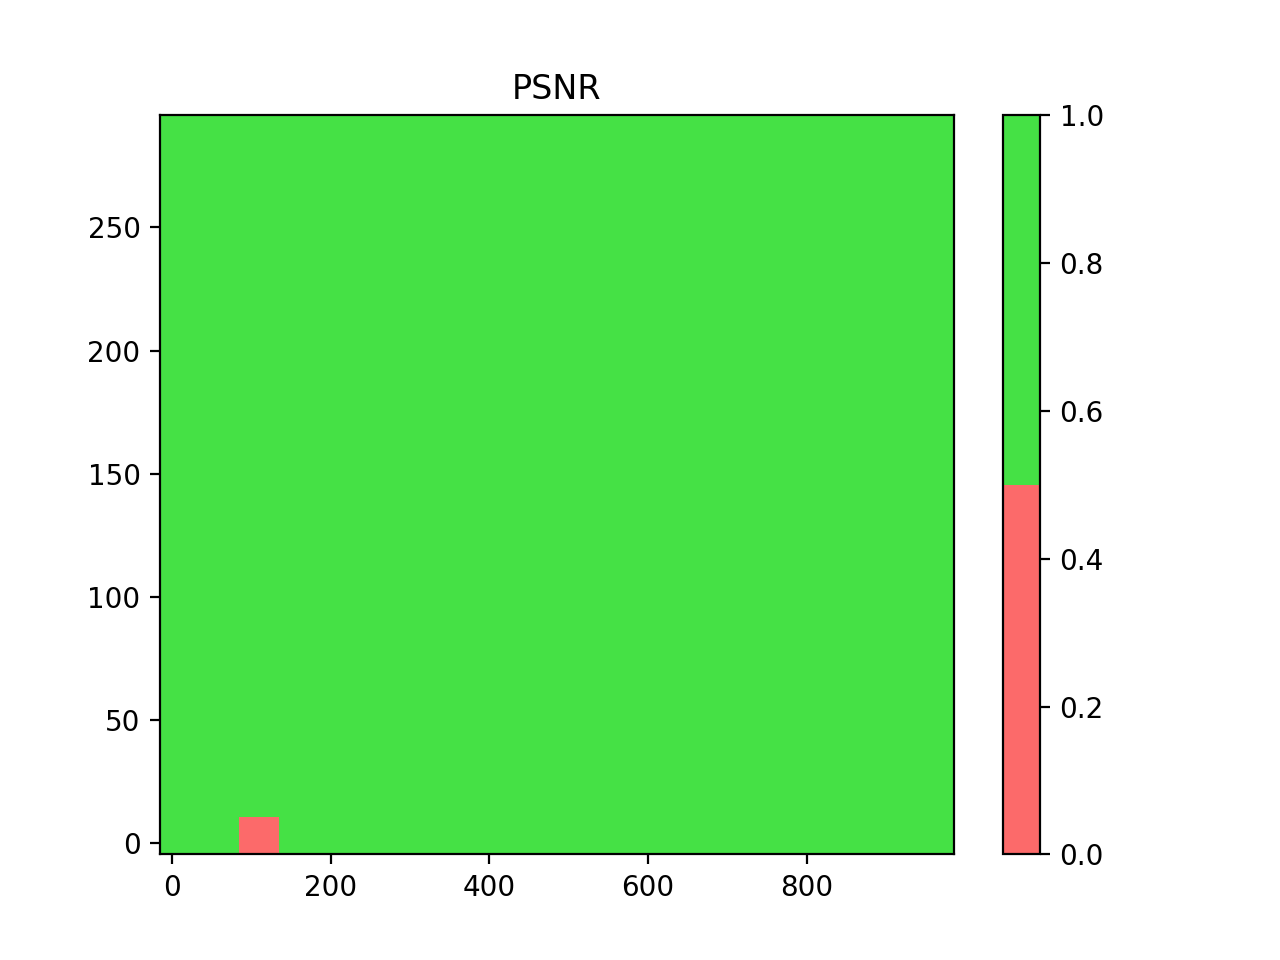

<IPython.core.display.Javascript object>


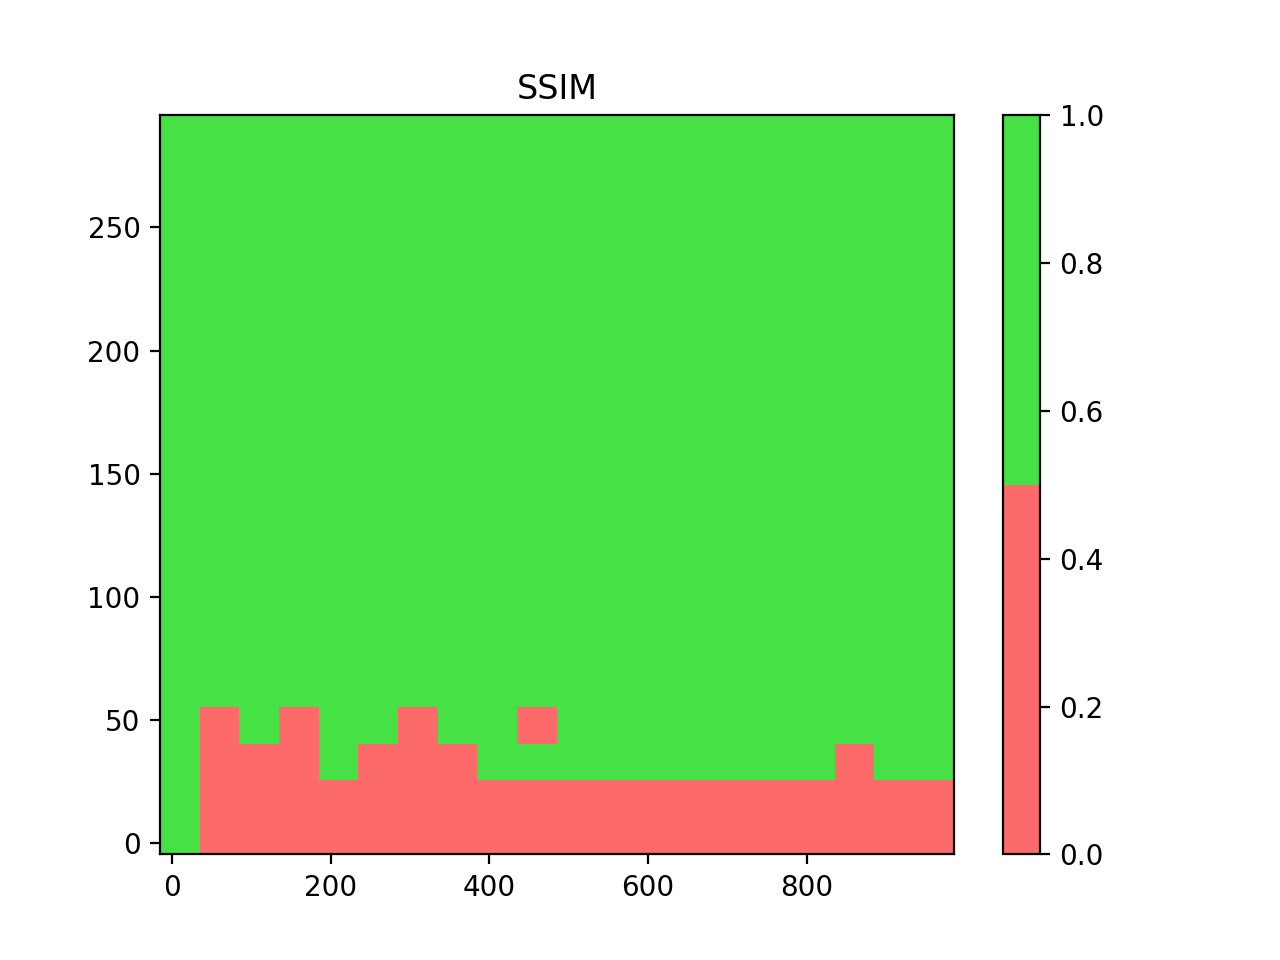

<IPython.core.display.Javascript object>


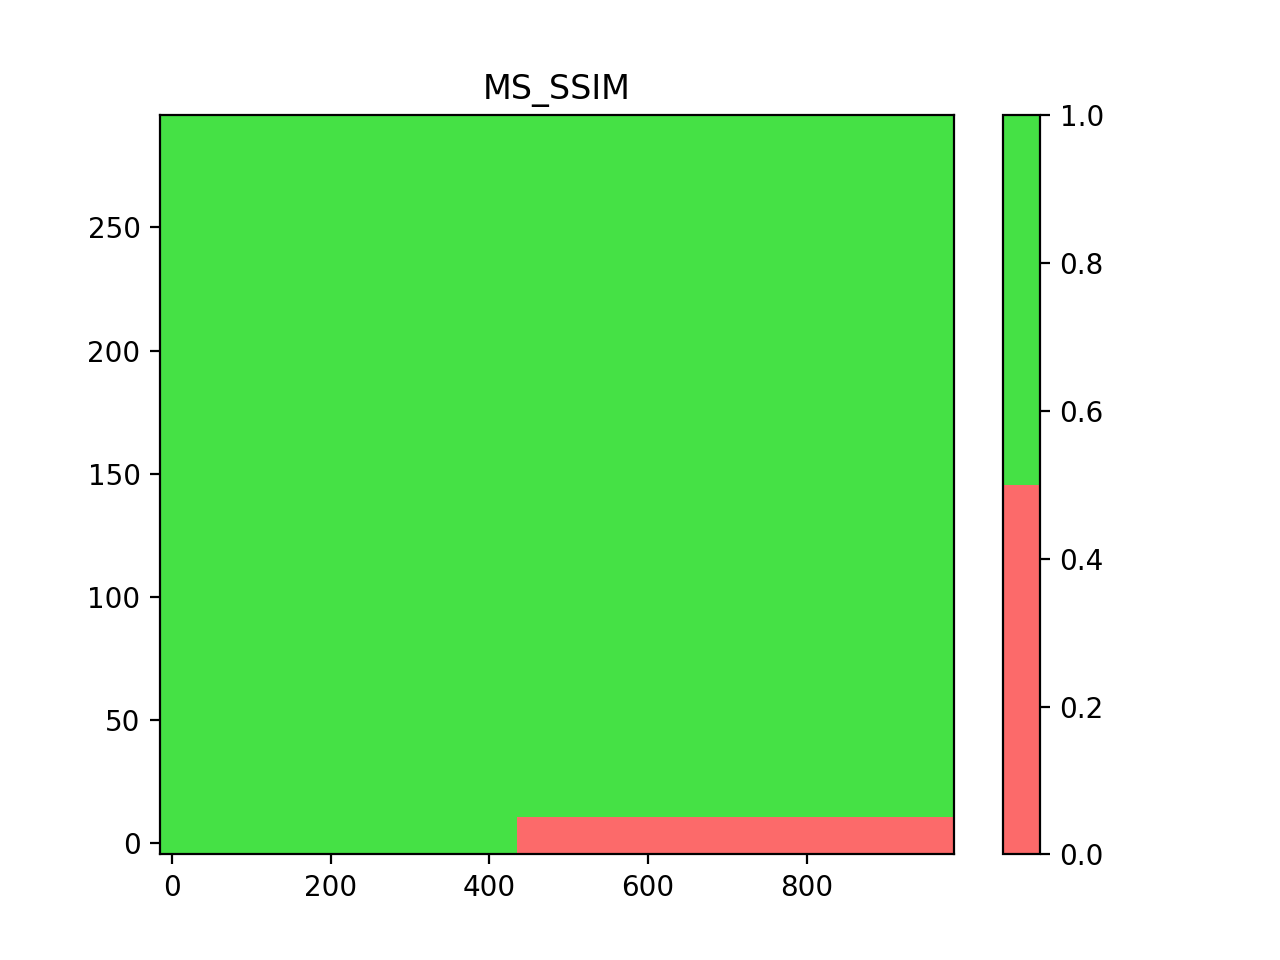

In [45]:
# 5 separate plots based on the map_tensor_5 data 
# source: https://stackoverflow.com/questions/43971138/python-plotting-colored-grid-based-on-values
# create discrete colormap
cmap = colors.ListedColormap(['#FC6A6A', '#45E145'])
bounds = [1,2]
norm = colors.BoundaryNorm(bounds, cmap.N)

y, x = np.meshgrid(ticks_X, ticks_Y)

for idx in range(map_tensor_5.shape[0]):
    z = map_tensor_5[idx].numpy()
    fig, ax = plt.subplots()
    c = ax.pcolormesh(x, y, z, cmap=cmap)
    ax.set_title(metrics_list[idx])

    fig.colorbar(c, ax=ax)

plt.show()